# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

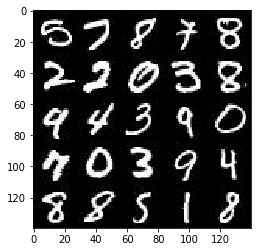

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

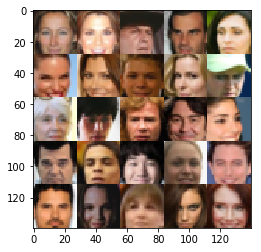

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, 
                                                    image_height, 
                                                    image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,
                                   name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [1]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    def leaky_relu(x, alpha=0.1, name='leaky_relu'): # hidden from outer code
            return tf.maximum(x, alpha * x, name=name)
        
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        #relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.maximum(x1, alpha * x1, name=name)
        # 14x14x32

        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        #relu2 = tf.maximum(0.1 * bn2, bn2)
        relu2 = tf.maximum(bn2, alpha * bn2, name=name)
        # 7x7x64
        
        #x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(0.01 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.sigmoid(logits)

    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

NameError: name 'tests' is not defined

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 16x16x128 now
        
        output = tf.tanh(logits)
    
    return output
    
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))    
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)    

        # Now for the transpose convolutions..    

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)    

        #x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='SAME')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha*x3, x3)    

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')
        output = tf.tanh(logits)
    return output
    """

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label Smoothing helps the discriminator generalize better, 
    #Thus the labels are reduced a bit from 1.0 to 0.9 using the parameter smooth
    
    smooth=0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss

   
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    #d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN      
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    class GAN:
        def __init__(self, real_size, z_size, learning_rate, alpha=0.1, beta1=0.5):
            #tf.reset_default_graph()
            
            image_width = data_shape[1]
            image_height = data_shape[2]
            image_channels = data_shape[3]
            self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, 
                                                                             image_height,
                                                                             image_channels,
                                                                             z_size)

            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                                  real_size[3])

            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

    net = GAN(data_shape, z_dim, learning_rate, alpha=0.1, beta1=beta1)
    
    losses = []
    samples = []
    batches = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                batches += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})

                if batches % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if batches % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, data_shape[3], is_train=False),
                                   feed_dict={net.input_z: batch_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                    plt.show()

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.0278
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 1.1494
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.2661
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 0.9331


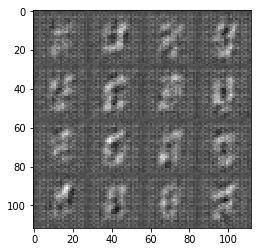

Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.2627
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 1.3738
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.1899
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.4647
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.4332
Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 0.7981... Generator Loss: 1.4616
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 1.5206


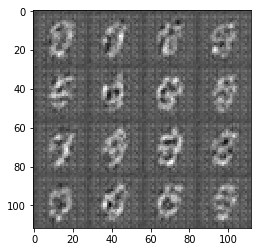

Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 1.6397
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 1.5904
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 0.7030... Generator Loss: 1.6136
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 1.4968
Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.8041
Epoch 1/2... Discriminator Loss: 0.6389... Generator Loss: 1.8194
Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 1.9149
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.8946


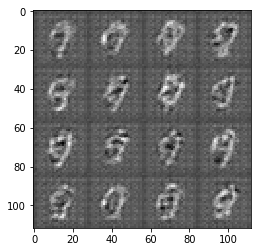

Epoch 1/2... Discriminator Loss: 0.6047... Generator Loss: 1.9983
Epoch 1/2... Discriminator Loss: 0.6278... Generator Loss: 1.7081
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.8977
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 1.9746
Epoch 1/2... Discriminator Loss: 0.6177... Generator Loss: 2.0291
Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 2.0451
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 2.1784
Epoch 1/2... Discriminator Loss: 0.5437... Generator Loss: 2.1812
Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 2.0618
Epoch 1/2... Discriminator Loss: 0.5725... Generator Loss: 2.0318


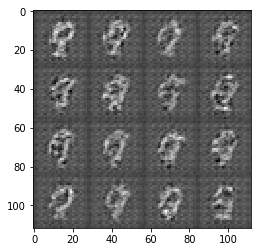

Epoch 1/2... Discriminator Loss: 0.5661... Generator Loss: 1.9526
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 2.2463
Epoch 1/2... Discriminator Loss: 0.5217... Generator Loss: 2.1625
Epoch 1/2... Discriminator Loss: 0.5780... Generator Loss: 2.0231
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 2.3867
Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 2.4033
Epoch 2/2... Discriminator Loss: 0.5402... Generator Loss: 2.2172
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 2.3160
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 2.3890
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 2.3696


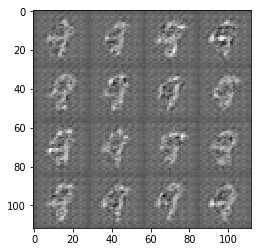

Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 2.5580
Epoch 2/2... Discriminator Loss: 0.5399... Generator Loss: 2.5067
Epoch 2/2... Discriminator Loss: 0.5056... Generator Loss: 2.4545
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 2.6212
Epoch 2/2... Discriminator Loss: 0.5421... Generator Loss: 2.0311
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 2.3495
Epoch 2/2... Discriminator Loss: 0.4930... Generator Loss: 2.4791
Epoch 2/2... Discriminator Loss: 0.4971... Generator Loss: 2.5018
Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.5270
Epoch 2/2... Discriminator Loss: 0.4946... Generator Loss: 2.4726


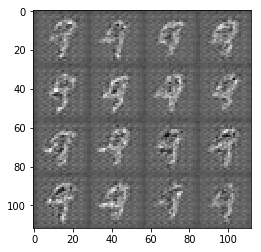

Epoch 2/2... Discriminator Loss: 0.5488... Generator Loss: 2.1690
Epoch 2/2... Discriminator Loss: 0.5054... Generator Loss: 2.4568
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 2.7105
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 2.3980
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 2.4860
Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 2.5024
Epoch 2/2... Discriminator Loss: 0.4860... Generator Loss: 2.7694
Epoch 2/2... Discriminator Loss: 0.4680... Generator Loss: 2.6504
Epoch 2/2... Discriminator Loss: 0.4740... Generator Loss: 2.7203
Epoch 2/2... Discriminator Loss: 0.4634... Generator Loss: 2.6427


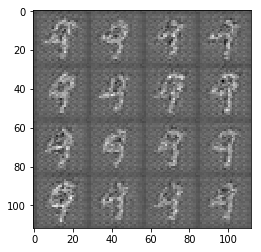

Epoch 2/2... Discriminator Loss: 0.4697... Generator Loss: 2.6659
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 2.5686
Epoch 2/2... Discriminator Loss: 0.4700... Generator Loss: 2.6747
Epoch 2/2... Discriminator Loss: 0.4693... Generator Loss: 2.6878
Epoch 2/2... Discriminator Loss: 0.4664... Generator Loss: 2.6244
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 2.7020
Epoch 2/2... Discriminator Loss: 0.4759... Generator Loss: 2.6037
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 2.6499
Epoch 2/2... Discriminator Loss: 0.4534... Generator Loss: 2.6480
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 2.8341


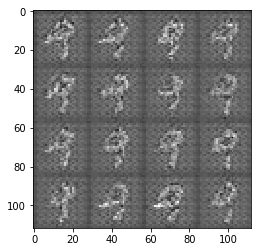

Epoch 2/2... Discriminator Loss: 0.4695... Generator Loss: 2.5982
Epoch 2/2... Discriminator Loss: 0.5399... Generator Loss: 2.5555
Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 2.7995
Epoch 2/2... Discriminator Loss: 0.4599... Generator Loss: 2.7657
Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 2.9125
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 2.7861
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 2.8589
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 2.4773
Epoch 2/2... Discriminator Loss: 0.4508... Generator Loss: 2.7285
Epoch 2/2... Discriminator Loss: 0.4454... Generator Loss: 2.8032


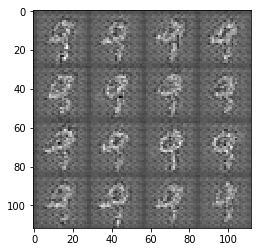

Epoch 2/2... Discriminator Loss: 0.4607... Generator Loss: 2.6493
Epoch 2/2... Discriminator Loss: 0.5049... Generator Loss: 2.7437
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 2.7992


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

#What to print
print_every = 10
show_every = 100

import matplotlib.pyplot as plt
import pickle as pkl

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.2647
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.3876


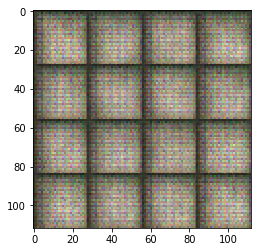

Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.4098
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.9930
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 2.5716
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 2.0324
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.6825
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 3.6017


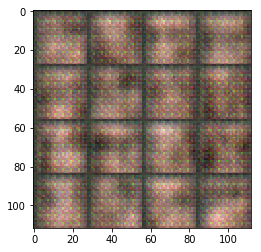

Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 5.0239
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 5.3869
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 3.6619
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 1.6912
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.7192
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 2.8489
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.2964
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 3.1881


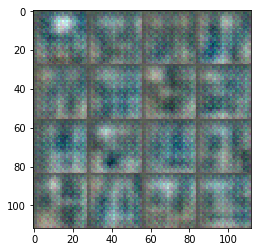

Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.4494
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.0056
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 4.1085
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 4.4076
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 5.5878
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.1382
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 3.2709


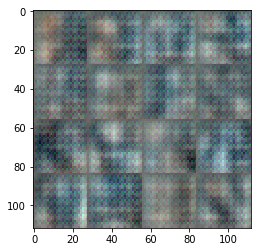

Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.9675
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 3.6738
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 5.5044
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 6.0833
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.4698
Epoch 1/1... Discriminator Loss: 0.5010... Generator Loss: 5.7319
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 6.6854
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 5.1917
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 3.5148


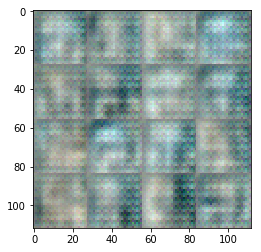

Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 6.8863
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 3.3201
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 5.8559
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 6.9721
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.6421
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 6.2739
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 4.5390
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 4.2149


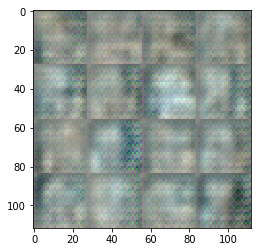

Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 5.0067
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.7110
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 5.2255
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.3708
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 5.6231
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 3.8357
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 6.7751
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 4.3843
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 5.8115
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 6.9627


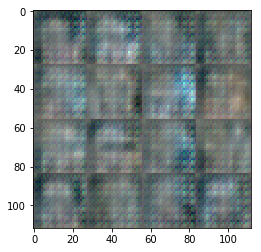

Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 6.2204
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 4.2270
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 3.2054
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 9.1620
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 4.0638
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 4.2703
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 4.3631
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 6.7530
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 5.2046


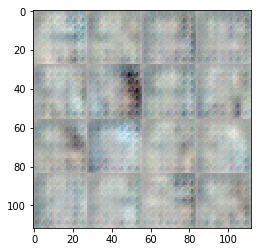

Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 3.5321
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 8.5016
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 5.4389
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 5.4527
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.8284
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 7.4023
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 8.1391
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 9.6578
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 3.9794
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.4495


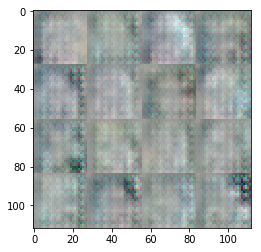

Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.2952
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 8.0060
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 4.3523
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.3853
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 4.4670
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 5.8972
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 4.8313
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 5.8418
Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 2.7839


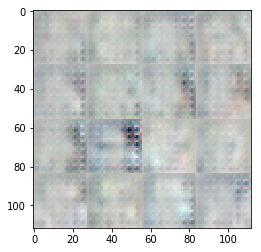

Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.7896
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.7888
Epoch 1/1... Discriminator Loss: 0.3777... Generator Loss: 4.5361
Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 5.4808
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 7.8446
Epoch 1/1... Discriminator Loss: 0.3904... Generator Loss: 4.8544
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 6.0764
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 1.7413
Epoch 1/1... Discriminator Loss: 0.3631... Generator Loss: 5.1737


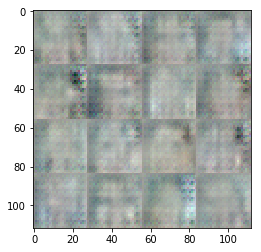

Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 5.1572
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 6.8076
Epoch 1/1... Discriminator Loss: 0.6857... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 8.5363
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 4.3193
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 9.0521
Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 5.4913
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 5.7991
Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 6.5698
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 8.1572


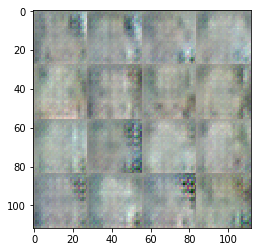

Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 10.4137
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 10.0835
Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 9.9047
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 3.9700
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 3.6155
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.3172
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 11.1973
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 6.2444
Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 7.2969
Epoch 1/1... Discriminator Loss: 0.3644... Generator Loss: 4.7098


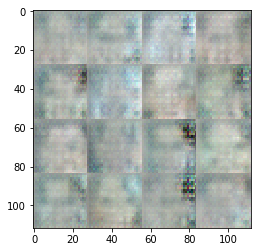

Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 5.8440
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 7.7491
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 5.3485
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 6.1003
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 6.8668
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 8.0689
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 6.0819
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 5.8660
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 9.4842
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 4.6067


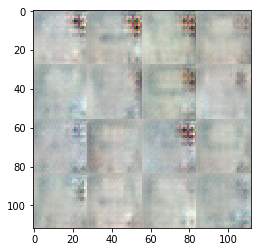

Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 6.4231
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 3.7348
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.7736
Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 6.6120
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.8531
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.6353
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 7.3016
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 10.4805
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 5.8043
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 7.2184


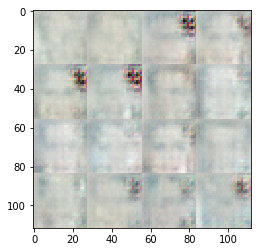

Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 5.7361
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 2.6848
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.7931
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 4.3487
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 9.9507
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 6.5031
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 5.9354
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 3.6654


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

#What to print
print_every = 10
show_every = 100

import matplotlib.pyplot as plt
import pickle as pkl


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.